In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define the dataset directory
data_root = r"/content/drive/MyDrive/stryker/PS3 Train"
sequences = ["seq_1", "seq_2", "seq_3", "seq_4", "seq_5", "seq_6", "seq_7", "seq_9", "seq_10", "seq_11", "seq_12", "seq_13", "seq_14", "seq_15", "seq_16"]

# Collect frame and label paths
frame_paths = []
label_paths = []

for sequence in sequences:
    sequence_dir = os.path.join(data_root, sequence)

    if not os.path.isdir(sequence_dir):
        print("Not a directory:", sequence_dir)
        continue

    frames_dir = os.path.join(sequence_dir, "frames")
    labels_dir = os.path.join(sequence_dir, "labels")

    if not (os.path.isdir(frames_dir) and os.path.isdir(labels_dir)):
        print("Frames or labels directory does not exist for sequence:", sequence)
        continue

    frame_files = sorted([os.path.join(frames_dir, file) for file in os.listdir(frames_dir) if file.endswith(".png")])
    label_files = sorted([os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith(".png")])

    for frame_file, label_file in zip(frame_files, label_files):
        frame_paths.append(frame_file)
        label_paths.append(label_file)

# Check the collected paths
print("Frame paths:", frame_paths[:5])  # Print first 5 paths for inspection
print("Label paths:", label_paths[:5])  # Print first 5 paths for inspection

# Step 2: Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(frame_paths, label_paths, test_size=0.2, random_state=42)

# Print the shape of the datasets
print("Training images:", len(train_images))
print("Validation images:", len(val_images))
print("Training masks:", len(train_masks))
print("Validation masks:", len(val_masks))

# Step 4: Define data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_size):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def preprocess_image(self, img):
        img = img.resize(self.image_size)
        img = np.array(img)
        img = img / 255.0  # Normalize pixel values to [0, 1]
        return img

    def preprocess_mask(self, mask):
        mask = mask.resize(self.image_size)
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize pixel values to [0, 1]
        return mask

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = np.array([self.preprocess_image(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size)) for file in batch_image_files])
        batch_masks = np.array([self.preprocess_mask(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size, color_mode="grayscale")) for file in batch_mask_files])

        return batch_images, batch_masks

# Step 5: Define U-Net model
def unet(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    return tf.keras.Model(inputs=inputs, outputs=conv10)

# Step 6: Compile the model
model = unet(input_size=(256, 256, 3))  # Adjust input size
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Create data generators
batch_size = 32
train_generator = DataGenerator(train_images, train_masks, batch_size, (256, 256))  # Adjust image size
val_generator = DataGenerator(val_images, val_masks, batch_size, (256, 256))  # Adjust image size

# Step 8: Train the model
history = model.fit(train_generator, epochs=2, steps_per_epoch=len(train_generator),
                    validation_data=val_generator, validation_steps=len(val_generator))

# Step 9: Evaluate the model (if needed)
evaluation_results = model.evaluate(val_generator, steps=len(val_generator))
print("Evaluation results:", evaluation_results)


Frame paths: ['/content/drive/MyDrive/stryker/PS3 Train/seq_1/frames/frame000.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/frames/frame001.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/frames/frame002.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/frames/frame003.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/frames/frame004.png']
Label paths: ['/content/drive/MyDrive/stryker/PS3 Train/seq_1/labels/frame000.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/labels/frame001.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/labels/frame002.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/labels/frame003.png', '/content/drive/MyDrive/stryker/PS3 Train/seq_1/labels/frame004.png']
Training images: 1788
Validation images: 447
Training masks: 1788
Validation masks: 447
Epoch 1/2
55/55 [==============================] - 1002s 18s/step - loss: 0.2529 - accuracy: 0.8283 - val_loss: 0.0980 - val_accuracy: 0.8312
Epoch 2/2
13/13 [=========================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('unet_2epoch_binry.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 361ms/step


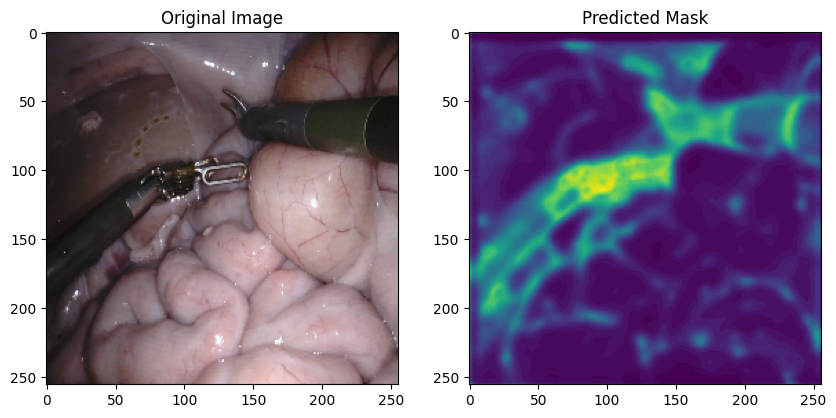

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

input_image_path = '/content/drive/MyDrive/stryker/PS3 Train/seq_16/frames/frame000.png'
input_image = load_img(input_image_path, target_size=(256, 256))
input_image = img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
input_image = input_image / 255.0  # Normalize to [0, 1]

predicted_mask = model.predict(input_image)

predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
predicted_mask = (predicted_mask * 255).astype(np.uint8)  # Scale to [0, 255] if needed

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(input_image))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')

plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define the dataset directory
data_root = r"/content/drive/MyDrive/stryker/PS3 Train"
sequences = ["seq_1", "seq_2", "seq_3", "seq_4", "seq_5", "seq_6", "seq_7", "seq_9", "seq_10", "seq_11", "seq_12", "seq_13", "seq_14", "seq_15", "seq_16"]

# Collect frame and label paths
frame_paths = []
label_paths = []

for sequence in sequences:
    sequence_dir = os.path.join(data_root, sequence)

    if not os.path.isdir(sequence_dir):
        print("Not a directory:", sequence_dir)
        continue

    frames_dir = os.path.join(sequence_dir, "frames")
    labels_dir = os.path.join(sequence_dir, "labels")

    if not (os.path.isdir(frames_dir) and os.path.isdir(labels_dir)):
        print("Frames or labels directory does not exist for sequence:", sequence)
        continue

    frame_files = sorted([os.path.join(frames_dir, file) for file in os.listdir(frames_dir) if file.endswith(".png")])
    label_files = sorted([os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith(".png")])

    for frame_file, label_file in zip(frame_files, label_files):
        frame_paths.append(frame_file)
        label_paths.append(label_file)

# Step 2: Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(frame_paths, label_paths, test_size=0.2, random_state=42)

# Step 4: Define data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_size):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def preprocess_image(self, img):
        img = img.resize(self.image_size)
        img = np.array(img)
        img = img / 255.0  # Normalize pixel values to [0, 1]
        return img

    def preprocess_mask(self, mask):
        mask = mask.resize(self.image_size)
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize pixel values to [0, 1]
        return mask

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = np.array([self.preprocess_image(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size)) for file in batch_image_files])
        batch_masks = np.array([self.preprocess_mask(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size, color_mode="grayscale")) for file in batch_mask_files])

        return batch_images, batch_masks

# Step 5: Define U-Net model
def unet(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)

    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(conv9)  # Change to 3 channels
    # Change the activation function to sigmoid and output 3 channels

    return tf.keras.Model(inputs=inputs, outputs=conv9)

# Step 6: Compile the model
model = unet(input_size=(256, 256, 3))  # Adjust input size
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Create data generators
batch_size = 32
train_generator = DataGenerator(train_images, train_masks, batch_size, (256, 256))  # Adjust image size
val_generator = DataGenerator(val_images, val_masks, batch_size, (256, 256))  # Adjust image size

# Step 8: Train the model
history = model.fit(train_generator, epochs=2, steps_per_epoch=len(train_generator),
                    validation_data=val_generator, validation_steps=len(val_generator))

# Step 9: Evaluate the model (if needed)
evaluation_results = model.evaluate(val_generator, steps=len(val_generator))
print("Evaluation results:", evaluation_results)

# Step 10: Save the model
model.save("unet_model.h5")


Epoch 1/2
55/55 [==============================] - 1191s 21s/step - loss: 0.1751 - accuracy: 0.4406 - val_loss: 0.1038 - val_accuracy: 0.1541
Epoch 2/2
13/13 [==============================] - 37s 3s/step - loss: 0.1066 - accuracy: 0.6800
Evaluation results: [0.10661916434764862, 0.6799739003181458]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 202ms/step


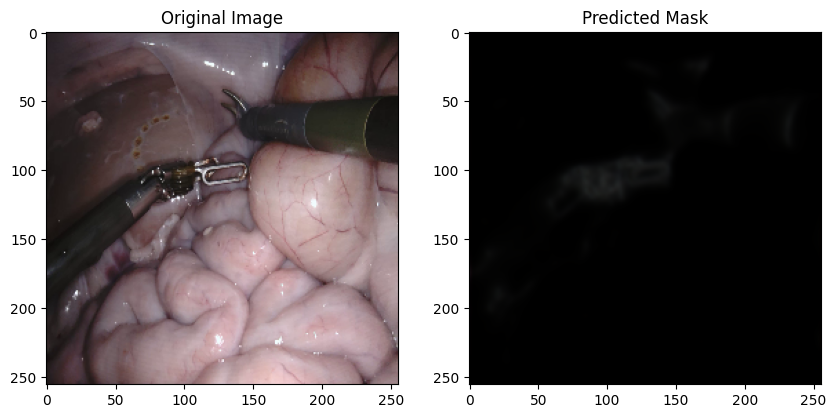

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

input_image_path = '/content/drive/MyDrive/stryker/PS3 Train/seq_16/frames/frame000.png'
input_image = load_img(input_image_path, target_size=(256, 256))
input_image = img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
input_image = input_image / 255.0  # Normalize to [0, 1]

predicted_mask = model.predict(input_image)

predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
#predicted_mask = (predicted_mask * 255).astype(np.uint8)  # Scale to [0, 255] if needed

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(input_image))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')

plt.show()

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
!pip install segmentation_models

   ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
   ---------------------------------------- 50.7/50.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   --- ------------------------------------ 1.1/12.7 MB 24.2 MB/s eta 0:00:01
   ------ --------------------------------- 2.0/12.7 MB 21.2 MB/s eta 0:00:01
   --------- ------------------------------ 3.0/12.7 MB 21.4 MB/s eta 0:00:01
   ------------ --------------------------- 4.0/12.7 MB 21.4 MB/s eta 0:00:01
   ---------------- ----------------------- 5.4/12.7 MB 22.9 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.7 MB 24.1 MB/s eta 0:00:01
   -------------------------- ------------- 8.3/12.7 MB 25.4 MB/s eta 0:00:01
   ------------------------------- -------- 10.1/12.7 MB 26.8 MB/s eta 0:00:01
   ------------------------------------- -- 12.0/12.7 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------  12.7/12.7 MB 32.7 MB/s eta 0:00:01
   ---

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the dataset directory
data_root = r"PS3 Train/PS3 Train"
sequences = ["seq_1", "seq_2", "seq_3", "seq_4", "seq_5", "seq_6", "seq_7", "seq_9", "seq_10", "seq_11", "seq_12", "seq_13", "seq_14", "seq_15", "seq_16"]

# Collect frame and label paths
frame_paths = []
label_paths = []

for sequence in sequences:
    sequence_dir = os.path.join(data_root, sequence)

    if not os.path.isdir(sequence_dir):
        print("Not a directory:", sequence_dir)
        continue

    frames_dir = os.path.join(sequence_dir, "frames")
    labels_dir = os.path.join(sequence_dir, "labels")

    if not (os.path.isdir(frames_dir) and os.path.isdir(labels_dir)):
        print("Frames or labels directory does not exist for sequence:", sequence)
        continue

    frame_files = sorted([os.path.join(frames_dir, file) for file in os.listdir(frames_dir) if file.endswith(".png")])
    label_files = sorted([os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith(".png")])

    for frame_file, label_file in zip(frame_files, label_files):
        frame_paths.append(frame_file)
        label_paths.append(label_file)

# Step 2: Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(frame_paths, label_paths, test_size=0.2, random_state=42)

# Step 4: Define data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_size):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def preprocess_image(self, img):
        img = img.resize(self.image_size)
        img = np.array(img)
        img = img / 255.0  # Normalize pixel values to [0, 1]
        return img

    def preprocess_mask(self, mask):
        mask = mask.resize(self.image_size)
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        mask = mask / 255.0  # Normalize pixel values to [0, 1]
        return mask

    def __getitem__(self, index):
        batch_image_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_files = self.mask_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = np.array([self.preprocess_image(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size)) for file in batch_image_files])
        batch_masks = np.array([self.preprocess_mask(tf.keras.preprocessing.image.load_img(file, target_size=self.image_size, color_mode="grayscale")) for file in batch_mask_files])

        return batch_images, batch_masks

# Step 5: Define U-Net model
def unet(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)

    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(3, 3, activation='softmax', padding='same')(conv9)  # Change to 3 channels

    return tf.keras.Model(inputs=inputs, outputs=conv9)

# Step 6: Compile the model
model = unet(input_size=(256, 256, 3))  # Adjust input size
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=[sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5)])

# Step 7: Create data generators
batch_size = 8
train_generator = DataGenerator(train_images, train_masks, batch_size, (256, 256))  # Adjust image size
val_generator = DataGenerator(val_images, val_masks, batch_size, (256, 256))  # Adjust image size

# Step 8: Define callbacks for learning rate scheduling and early stopping
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = 3*lr / 2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 9: Train the model with callbacks
history = model.fit(train_generator, epochs=30, steps_per_epoch=len(train_generator),
                    validation_data=val_generator, validation_steps=len(val_generator),
                    callbacks=[lr_callback, early_stopping],batch_size=8)

# Step 10: Evaluate the model (if needed)
evaluation_results = model.evaluate(val_generator, steps=len(val_generator))
print("Evaluation results:", evaluation_results)

# Step 11: Save the model
model.save("unet_model_softmax_epochs_50.h5")


Epoch 1/30
223/223 [==============================] - 131s 575ms/step - loss: 0.0230 - iou_score: 1.2263e-04 - f1-score: 2.4004e-04 - val_loss: 0.0162 - val_iou_score: 1.3993e-06 - val_f1-score: 2.7977e-06 - lr: 0.0010
Epoch 2/30
223/223 [==============================] - 128s 573ms/step - loss: 0.0154 - iou_score: 8.9112e-07 - f1-score: 1.7814e-06 - val_loss: 0.0144 - val_iou_score: 6.8330e-07 - val_f1-score: 1.3658e-06 - lr: 0.0010
Epoch 3/30
223/223 [==============================] - 128s 574ms/step - loss: 0.0140 - iou_score: 3.2880e-07 - f1-score: 6.5676e-07 - val_loss: 0.0137 - val_iou_score: 2.2127e-06 - val_f1-score: 4.4237e-06 - lr: 0.0010
Epoch 4/30
223/223 [==============================] - 129s 574ms/step - loss: 0.0130 - iou_score: 1.1472e-07 - f1-score: 2.2860e-07 - val_loss: 0.0134 - val_iou_score: 8.2438e-10 - val_f1-score: 8.2438e-10 - lr: 0.0010
Epoch 5/30
223/223 [==============================] - 131s 585ms/step - loss: 0.0128 - iou_score: 8.2565e-10 - f1-score: 8.2